# reconstruction comparison after training

we compare reconstructions from different trained models on the same test images

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import glob
import time
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from collections import defaultdict

sys.path.append('../..')
sys.path.append('../../notebooks/cifar')

import interflow as itf
import interflow.stochastic_interpolant as stochastic_interpolant

# we import network architectures from training script
from cifar10lsun_patched_interpolants import (
    UNetDenoiser,
    EtaNetwork,
    VelocityNetwork,
    SinusoidalTimeEmbedding,
    TimeResBlock,
    NUM_CHANNELS,
    IMAGE_HEIGHT,
    IMAGE_WIDTH,
    IMAGE_SIZE,
    DATASET_NAME,
)

# we define create_patch_mask locally since it uses constants
def create_patch_mask(bs, patch_size=6, num_patches=4):
    """we create random patch masks, 1 for visible pixels, 0 for masked patches"""
    mask = torch.ones(bs, NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)  # we initialize mask for rgb images
    for i in range(bs):
        for _ in range(num_patches):
            x = torch.randint(0, max(1, IMAGE_HEIGHT - patch_size + 1), (1,)).item()  # we sample patch row
            y = torch.randint(0, max(1, IMAGE_WIDTH - patch_size + 1), (1,)).item()  # we sample patch column
            mask[i, :, x:x+patch_size, y:y+patch_size] = 0  # we mask the patch
    return mask.to(itf.util.get_torch_device())

RESULTS_ROOT = os.path.join("..", "..", "vresults", "cifarpatchedinterpolants")  # we store root for saved results
COMPARISON_ROOT = os.path.join("..", "..", "vresults", "comparisons")  # we store comparison results
os.makedirs(COMPARISON_ROOT, exist_ok=True)  # we ensure comparison directory exists

if torch.cuda.is_available():  # we set device
    print('cuda available, setting default tensor residence to gpu')
    itf.util.set_torch_device('cuda')
else:
    print('no cuda device found')
print(f"device: {itf.util.get_torch_device()}")

def grab(var):
    """we take a tensor off the gpu and convert it to a numpy array on the cpu"""
    return var.detach().cpu().numpy()

def denorm(img):
    """we denormalize and clamp to [0,1] for visualization"""
    denormed = img * 0.5 + 0.5  # we denormalize from [-1,1] to [0,1]
    return torch.clamp(denormed, 0.0, 1.0)  # we clamp to valid range

cuda available, setting default tensor residence to gpu
cuda
torch version: 2.9.1+cu128
[verbose] === starting dataset loading process ===
[verbose] max_samples: None
[verbose] loading celebA dataset...
[verbose] celebA root: /Data/janis.aiad/probgraph/data/celeba
[verbose] using transform: Resize(64x64) -> ToTensor -> Normalize
[verbose] ✓ gdown is already installed


/Data/janis.aiad/probgraph/.venv/lib/python3.12/site-packages/torch/__init__.py:1275: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)
Downloading...
From (original): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
From (redirected): https://drive.usercontent.google.com/download?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&confirm=t&uuid=d69c7899-0111-486a-8b7c-d25bcf7b8640
To: /Data/janis.aiad/probgraph/data/celeba/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:27<00:00, 51.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: /Data/janis.aiad/probgraph/data/celeba/celeba/list_attr_celeba.txt
100%|██████████| 26.7M/26.7M [00:00<00:00, 40.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_ee_0u7vcNLOfNLegJR

[verbose] ✓ celebA loaded successfully

loaded celebA train: 162770 images
[verbose] === dataset loading complete ===
[verbose] final trainset size: 162770 images
[verbose] device: cuda
cuda available, setting default tensor residence to gpu
device: cuda


In [2]:
def find_latest_checkpoints(
    dataset_tag: str,
    path: str,
    gamma_type: str,
    epsilon_tag: str,
    epoch: Optional[int] = None
) -> Optional[str]:
    """we find the latest checkpoint for a given configuration"""
    ckpt_dir = os.path.join(RESULTS_ROOT, dataset_tag, "checkpoints")  # we look in checkpoints directory
    if not os.path.exists(ckpt_dir):  # we check if directory exists
        return None
    
    if epoch is not None:  # we look for specific epoch
        ckpt_pattern = os.path.join(ckpt_dir, f"cifar_checkpoint_{path}_{gamma_type}_epoch_{epoch}.pt")
        if os.path.exists(ckpt_pattern):  # we check if specific checkpoint exists
            return ckpt_pattern
        return None
    
    # we find all checkpoints for this configuration
    pattern = os.path.join(ckpt_dir, f"cifar_checkpoint_{path}_{gamma_type}_epoch_*.pt")
    checkpoints = glob.glob(pattern)  # we list all matching checkpoints
    
    if not checkpoints:  # we check if any found
        return None
    
    # we extract epoch numbers and return latest
    def extract_epoch(ckpt_path: str) -> int:
        basename = os.path.basename(ckpt_path)  # we get filename
        epoch_str = basename.split('_epoch_')[1].split('.pt')[0]  # we extract epoch number
        return int(epoch_str)
    
    checkpoints.sort(key=extract_epoch, reverse=True)  # we sort by epoch descending
    return checkpoints[0]  # we return latest

def load_model_from_checkpoint(ckpt_path: str, device) -> Tuple[nn.Module, nn.Module, Dict]:
    """we load b and eta networks from checkpoint"""
    print(f"loading checkpoint: {os.path.basename(ckpt_path)}")  # we log checkpoint path
    ckpt = torch.load(ckpt_path, map_location=device)  # we load checkpoint
    
    # we extract configuration
    path = ckpt.get("path", "linear")  # we get path type
    gamma_type = ckpt.get("gamma_type", "bsquared")  # we get gamma type
    
    # we create networks
    unet_b = UNetDenoiser(in_channels=3, out_channels=3, base_channels=64)  # we create unet for b
    unet_eta = UNetDenoiser(in_channels=3, out_channels=3, base_channels=64)  # we create unet for eta
    
    b = VelocityNetwork(unet_b).to(device)  # we move b to device
    eta = EtaNetwork(unet_eta).to(device)  # we move eta to device
    
    # we load state dicts
    b.load_state_dict(ckpt["b_state_dict"])  # we load b weights
    eta.load_state_dict(ckpt["eta_state_dict"])  # we load eta weights
    
    b.eval()  # we set to eval mode
    eta.eval()  # we set to eval mode
    
    config = {
        "path": path,
        "gamma_type": gamma_type,
        "epsilon": ckpt.get("epsilon"),
        "epsilon_tag": ckpt.get("epsilon_tag", "eps-none"),
        "epoch": ckpt.get("epoch", 0),
    }  # we store configuration
    
    return b, eta, config  # we return networks and config

def reconstruct_with_model(
    b: nn.Module,
    eta: nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    x0s: torch.Tensor,
    n_step: int = 50
) -> torch.Tensor:
    """we reconstruct images using probability flow"""
    with torch.no_grad():  # we disable gradients
        s = stochastic_interpolant.SFromEta(eta, interpolant.a)  # we create s from eta
        pflow = stochastic_interpolant.PFlowIntegrator(
            b=b, method='rk4', interpolant=interpolant, n_step=n_step, sample_only=True
        )  # we create integrator
        xfs_pflow, _ = pflow.rollout(x0s)  # we integrate
        return xfs_pflow[-1]  # we return final reconstruction

In [3]:
# we set parameters
patch_size = 6  # we set patch size
num_patches = 4  # we set number of patches
num_test_samples = 8  # we set number of test images
epoch = None  # we use latest checkpoint (set to int for specific epoch, e.g., 4501)

print(f"patch_size: {patch_size}, num_patches: {num_patches}, num_test_samples: {num_test_samples}")
print(f"using {'latest' if epoch is None else f'epoch {epoch}'} checkpoint")

patch_size: 6, num_patches: 4, num_test_samples: 8
using latest checkpoint


loading dataset for test images...


100%|██████████| 170M/170M [00:05<00:00, 32.2MB/s] 


loaded 5000 dog images

generating 8 fixed test images...
test images shape: torch.Size([8, 3, 64, 64])
masked images shape: torch.Size([8, 3, 64, 64])


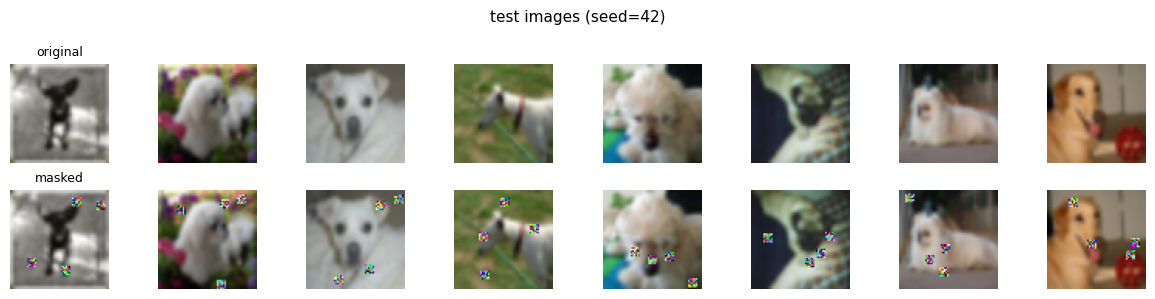

In [4]:
# we load dataset for test images
print("loading dataset for test images...")  # we log dataset loading
transform_cifar = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),  # we resize to target size
    transforms.ToTensor(),  # we convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # we normalize
])
cifar10_root = "../../data/cifar10"  # we set cifar10 root
trainset_cifar = torchvision.datasets.CIFAR10(
    root=cifar10_root, train=True, download=True, transform=transform_cifar
)  # we load cifar10
target_class = 5  # we select dog class
dog_indices = [i for i in range(len(trainset_cifar)) if trainset_cifar.targets[i] == target_class]  # we filter dog images
trainset = torch.utils.data.Subset(trainset_cifar, dog_indices)  # we create subset
print(f"loaded {len(trainset)} dog images")  # we log dataset size

# we generate fixed test images (same for all models)
print(f"\ngenerating {num_test_samples} fixed test images...")  # we log test generation
torch.manual_seed(42)  # we set seed for reproducibility
indices = torch.randint(0, len(trainset), (num_test_samples,))  # we sample random indices
x1s_img = torch.stack([trainset[i][0] for i in indices]).to(itf.util.get_torch_device())  # we get test batch
masks = create_patch_mask(num_test_samples, patch_size=patch_size, num_patches=num_patches)  # we create masks

# we create masked images
noise = torch.randn_like(x1s_img) * (1 - masks)  # we create noise
x0s_img = x1s_img * masks + noise  # we combine masked image and noise
x0s = x0s_img.reshape(num_test_samples, -1)  # we flatten for interpolant

print(f"test images shape: {x1s_img.shape}")  # we log shape
print(f"masked images shape: {x0s_img.shape}")  # we log shape

# we visualize test images
fig, axes = plt.subplots(2, num_test_samples, figsize=(num_test_samples * 1.5, 3))
for i in range(num_test_samples):
    img_orig = np.transpose(grab(denorm(x1s_img[i])), (1, 2, 0))  # we denormalize and transpose
    axes[0, i].imshow(img_orig)  # we display original
    axes[0, i].axis('off')  # we remove axes
    if i == 0:
        axes[0, i].set_title('original', fontsize=9)
    
    img_masked = np.transpose(grab(denorm(x0s_img[i])), (1, 2, 0))  # we denormalize and transpose
    axes[1, i].imshow(img_masked)  # we display masked
    axes[1, i].axis('off')  # we remove axes
    if i == 0:
        axes[1, i].set_title('masked', fontsize=9)

plt.suptitle(f'test images (seed=42)', fontsize=11)
plt.tight_layout()
plt.show()

In [5]:
# we define configurations to compare
paths = ["linear", "trig", "encoding-decoding"]  # we define paths
gamma_types = ["bsquared", "sinesquared", "sigmoid"]  # we define gamma types
epsilon_tags = ["eps-none", "eps-0.5", "eps-0.25"]  # we define epsilon tags

# we collect all reconstructions
reconstructions = {}  # we store reconstructions by model name
model_configs = {}  # we store model configurations

dataset_tag = f"{DATASET_NAME}_patch{patch_size}x{patch_size}_np{num_patches}"

print("loading models and running reconstructions...\n")

for epsilon_tag in epsilon_tags:  # we iterate over epsilon values
    full_dataset_tag = f"{dataset_tag}_{epsilon_tag}"  # we build full dataset tag
    
    for path in paths:  # we iterate over paths
        for gamma_type in gamma_types:  # we iterate over gamma types
            # we find checkpoint
            ckpt_path = find_latest_checkpoints(
                full_dataset_tag, path, gamma_type, epsilon_tag, epoch=epoch
            )  # we find latest checkpoint
            
            if ckpt_path is None:  # we skip if no checkpoint
                print(f"  ⚠ no checkpoint found for {path}_{gamma_type}_{epsilon_tag}, skipping...")
                continue
            
            # we load model
            try:  # we wrap in try-except
                b, eta, config = load_model_from_checkpoint(ckpt_path, itf.util.get_torch_device())  # we load model
                
                # we create interpolant
                interpolant = stochastic_interpolant.Interpolant(
                    path=config["path"], gamma_type=config["gamma_type"]
                )  # we create interpolant
                interpolant.gamma_type = config["gamma_type"]  # we store gamma type
                
                # we reconstruct
                print(f"  ✓ reconstructing with {path}_{gamma_type}_{epsilon_tag} (epoch {config['epoch']})...")
                xf_pflow = reconstruct_with_model(b, eta, interpolant, x0s, n_step=50)  # we reconstruct
                xf_pflow_img = xf_pflow.reshape(num_test_samples, NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)  # we reshape
                
                # we store reconstruction
                model_name = f"{path}_{gamma_type}_{epsilon_tag}"  # we build model name
                reconstructions[model_name] = xf_pflow_img  # we store reconstruction
                model_configs[model_name] = config  # we store config
                
                # we clear cache
                del b, eta, interpolant  # we delete models
                if torch.cuda.is_available():  # we clear cuda cache
                    torch.cuda.empty_cache()
                
            except Exception as e:  # we catch errors
                print(f"  ✗ error loading/reconstructing with {path}_{gamma_type}_{epsilon_tag}: {e}")
                import traceback
                traceback.print_exc()
                continue

print(f"\n✓ loaded {len(reconstructions)} models successfully")

loading models and running reconstructions...

  ⚠ no checkpoint found for linear_bsquared_eps-none, skipping...
  ⚠ no checkpoint found for linear_sinesquared_eps-none, skipping...
  ⚠ no checkpoint found for linear_sigmoid_eps-none, skipping...
  ⚠ no checkpoint found for trig_bsquared_eps-none, skipping...
  ⚠ no checkpoint found for trig_sinesquared_eps-none, skipping...
  ⚠ no checkpoint found for trig_sigmoid_eps-none, skipping...
  ⚠ no checkpoint found for encoding-decoding_bsquared_eps-none, skipping...
  ⚠ no checkpoint found for encoding-decoding_sinesquared_eps-none, skipping...
  ⚠ no checkpoint found for encoding-decoding_sigmoid_eps-none, skipping...
  ⚠ no checkpoint found for linear_bsquared_eps-0.5, skipping...
  ⚠ no checkpoint found for linear_sinesquared_eps-0.5, skipping...
  ⚠ no checkpoint found for linear_sigmoid_eps-0.5, skipping...
  ⚠ no checkpoint found for trig_bsquared_eps-0.5, skipping...
  ⚠ no checkpoint found for trig_sinesquared_eps-0.5, skipping...


In [6]:
# we create comprehensive comparison plot
if reconstructions:  # we check if any reconstructions
    num_models = len(reconstructions)  # we count models
    num_samples = x1s_img.shape[0]  # we get number of test images
    
    # we sort model names for consistent ordering
    sorted_models = sorted(reconstructions.keys())  # we sort model names
    
    # we compute grid dimensions
    ncols = 2 + num_models  # original + masked + reconstructions
    nrows = num_samples  # one row per sample
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2.2, nrows * 2.2))  # we create figure
    
    if nrows == 1:  # we handle single row case
        axes = axes[None, :]  # we add row dimension
    
    for i in range(num_samples):  # we iterate over samples
        # we show original image
        img_orig = np.transpose(grab(denorm(x1s_img[i])), (1, 2, 0))  # we denormalize and transpose
        axes[i, 0].imshow(img_orig)  # we display image
        axes[i, 0].axis('off')  # we remove axes
        if i == 0:
            axes[i, 0].set_title('original', fontsize=10, fontweight='bold')  # we set title
        
        # we show masked image
        img_masked = np.transpose(grab(denorm(x0s_img[i])), (1, 2, 0))  # we denormalize and transpose
        axes[i, 1].imshow(img_masked)  # we display image
        axes[i, 1].axis('off')  # we remove axes
        if i == 0:
            axes[i, 1].set_title(f'masked\n(patch={patch_size}x{patch_size})', fontsize=9, fontweight='bold')  # we set title
        
        # we show reconstructions
        for idx, model_name in enumerate(sorted_models):  # we iterate over models
            recon = reconstructions[model_name]  # we get reconstruction
            img_recon = np.transpose(grab(denorm(recon[i])), (1, 2, 0))  # we denormalize and transpose
            axes[i, 2 + idx].imshow(img_recon)  # we display image
            axes[i, 2 + idx].axis('off')  # we remove axes
            if i == 0:
                # we format model name for title
                title_parts = model_name.split('_')
                title = '\n'.join(title_parts)
                axes[i, 2 + idx].set_title(title, fontsize=8)
    
    plt.suptitle(f'reconstruction comparison - {num_samples} samples, {num_models} models', 
                 fontsize=13, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    # we save figure
    timestamp = time.strftime("%Y%m%d_%H%M%S")  # we create timestamp
    save_path = os.path.join(
        COMPARISON_ROOT,
        f"comparison_{timestamp}_patch{patch_size}x{patch_size}_np{num_patches}.png"
    )  # we build save path
    plt.savefig(save_path, dpi=150, bbox_inches="tight")  # we save figure
    print(f"saved comparison plot to {save_path}")  # we log save
    
    plt.show()  # we display in notebook
else:
    print("no reconstructions available for comparison")

no reconstructions available for comparison


In [7]:
# we create per-model detailed comparisons
if reconstructions:  # we check if any reconstructions
    for model_idx, (model_name, recon) in enumerate(sorted(reconstructions.items())):  # we iterate over models
        config = model_configs[model_name]  # we get config
        
        # we create detailed plot for this model
        ncols = 3  # original, masked, reconstructed
        nrows = num_test_samples  # one row per sample
        
        fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2.5, nrows * 2.5))  # we create figure
        
        if nrows == 1:  # we handle single row case
            axes = axes[None, :]  # we add row dimension
        
        for i in range(num_test_samples):  # we iterate over samples
            # we show original
            img_orig = np.transpose(grab(denorm(x1s_img[i])), (1, 2, 0))  # we denormalize and transpose
            axes[i, 0].imshow(img_orig)  # we display image
            axes[i, 0].axis('off')  # we remove axes
            if i == 0:
                axes[i, 0].set_title('original', fontsize=10, fontweight='bold')  # we set title
            
            # we show masked
            img_masked = np.transpose(grab(denorm(x0s_img[i])), (1, 2, 0))  # we denormalize and transpose
            axes[i, 1].imshow(img_masked)  # we display image
            axes[i, 1].axis('off')  # we remove axes
            if i == 0:
                axes[i, 1].set_title('masked', fontsize=10, fontweight='bold')  # we set title
            
            # we show reconstruction
            img_recon = np.transpose(grab(denorm(recon[i])), (1, 2, 0))  # we denormalize and transpose
            axes[i, 2].imshow(img_recon)  # we display image
            axes[i, 2].axis('off')  # we remove axes
            if i == 0:
                axes[i, 2].set_title('reconstructed', fontsize=10, fontweight='bold')  # we set title
        
        # we format title with model info
        title = f'{model_name.replace("_", " ")} - epoch {config["epoch"]}'
        plt.suptitle(title, fontsize=12, fontweight='bold', y=0.995)
        plt.tight_layout()
        
        # we save figure
        model_save_path = os.path.join(
            COMPARISON_ROOT,
            f"comparison_{model_name}_{timestamp}.png"
        )  # we build model-specific save path
        plt.savefig(model_save_path, dpi=150, bbox_inches="tight")  # we save figure
        print(f"saved detailed plot for {model_name} to {model_save_path}")  # we log save
        
        plt.show()  # we display in notebook
        print()  # we add blank line between models
else:
    print("no reconstructions available for detailed comparison")

no reconstructions available for detailed comparison
